# CMIP5: Apr Distribution Fits, 1981-2010

Downscaled CMIP5 simulation results were obtained using two downscaling methods period 1981-2010. These values have been collated into monthly collections of daily precipitation by grid cell and by group. Four groups were created using PCA and K-means clustering. The groups identified from PRISM data were also attributed to the grid locations.

CMIP5 data will be processed by grid cell and regions will not be used for fitting distributions. There are 4, 30-yr climate periods and expect different regionalization for each climate period. Consequently, the most direct approach will be to use the grid cells as independent regions and then we get the automatic variation.

- LOCA: 1/16 degree grid cells
- BCCA: 1/8 degree grid cells == NLDAS2 grid

## Parameters and Library Loading

In [1]:
oldw <- getOption("warn")

In [2]:
options(warn = -1)

In [3]:
library(feather)
library(moments)
library(dplyr)
library(fitdistrplus)
library(gendist)
library(mixtools)
library(xlsx)
library(r2excel)
library("IRdisplay")


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



LOCA grid to show which cells, **Grid_Id**, values are actually needed.

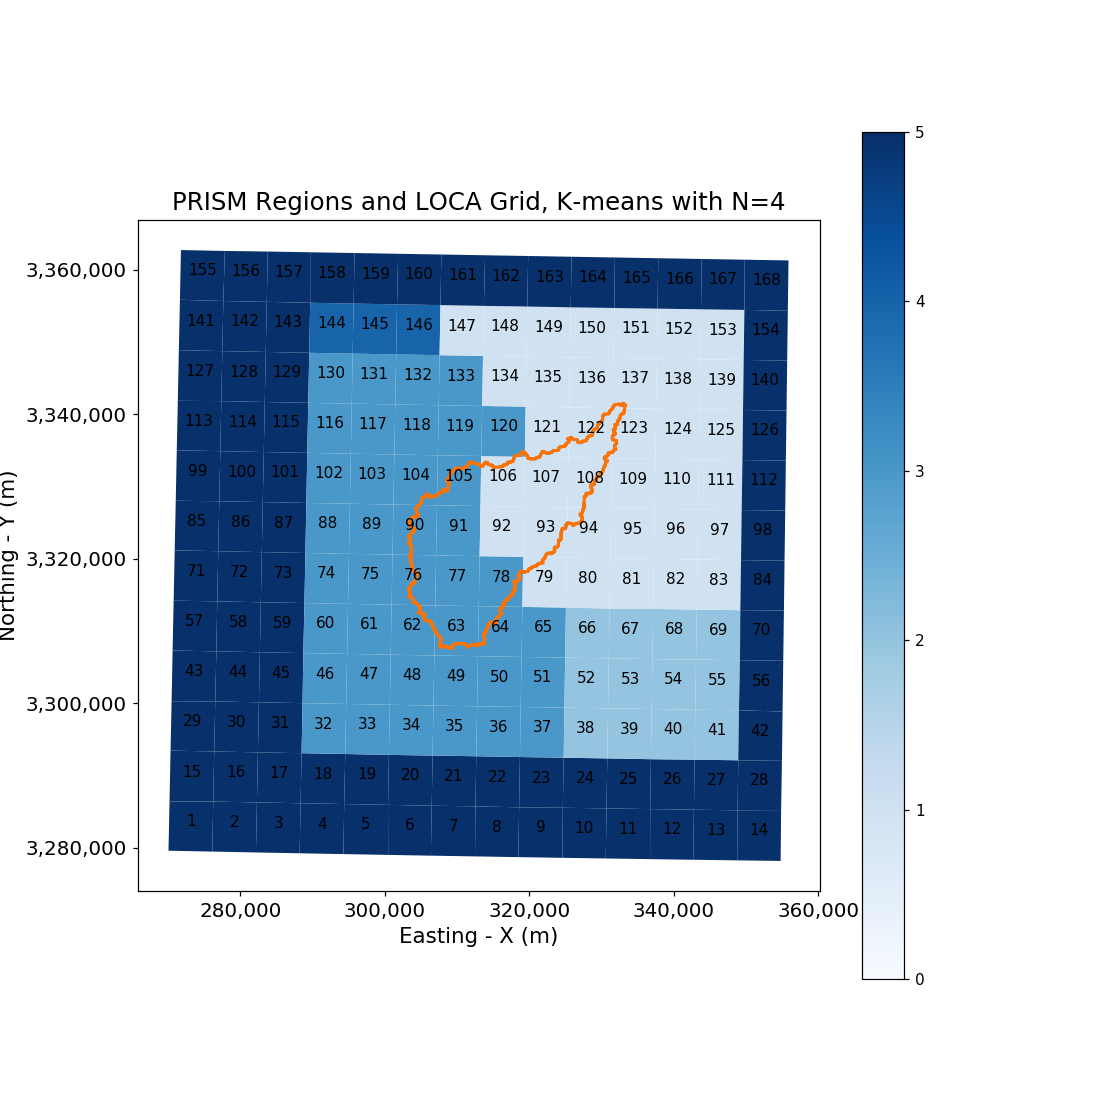

In [4]:
display_png(file="//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/JNotes/Images/PNG/Jan_LOCA_grid_PRISM_regions_.png")

In [5]:
LOCA_IDs <- c( 136, 137, 120, 121, 122, 123, 104, 105, 106, 107, 108, 109,
               90, 91, 92, 93, 94, 76, 77, 78, 79, 62, 63, 64 )

BCCA grid to show which BCCA cells are needed

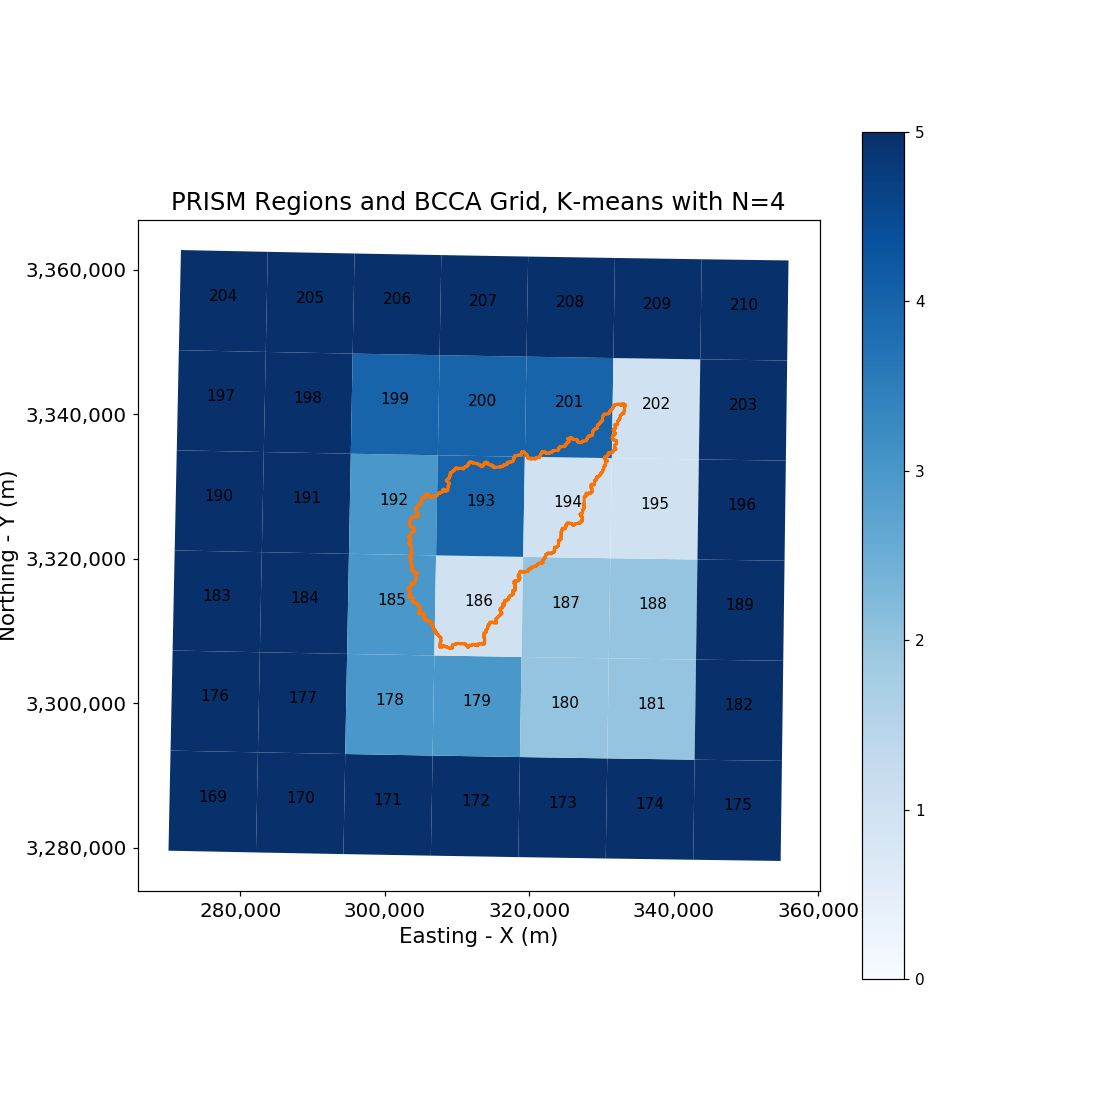

In [6]:
display_png(file="//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/JNotes/Images/PNG/Jan_BCCA_grid_PRISM_regions_.png")

In [7]:
BCCA_IDs <- c( 200, 201, 202, 192, 193, 194, 195, 185, 186, 187, 179 )

In [8]:
NBCGrid <- length( BCCA_IDs )
NLOGrid <- length( LOCA_IDs )
cat( "LOCA grid cells of interest: ", NLOGrid, " and BCCA grid cells of interest: ", NBCGrid )

LOCA grid cells of interest:  24  and BCCA grid cells of interest:  11

In [9]:
setwd("//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/R/Working/CMIP5_1981_PDepth")

Specify some parameters, primarily filenames

Have two different downscaled grids and so have a separate file for each.

In [10]:
feLONAM <- "Apr_WetDays_LOCA_Grp_1981-2010.feather"

In [11]:
fBCNAM <- "Apr_WetDays_BCCA_Grp_1981-2010.feather"

In [12]:
dfLOApr <- read_feather(feLONAM)

In [13]:
dfBCApr <- read_feather(fBCNAM)

In [14]:
dfPRISMApr <- read_feather( "//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/R/Working/Apr_WetDays_Grp_1981-2010.feather" )

## Apr Distribution Fits

Fit distributions for each defined grid cell in the header.

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use two, pre-selected distributions for fitting. The first distribution is the 2-parameter gamma distribution which is often used for precipitation depth. This distribution has some advantages in terms of fitting ability because of the two parameters relative to the exponential distribution which is one parameter.

The second distribution to try is the mixed exponential distribution which is a probability mixture of two one-parameter exponential distributions. It provides for the superposition of two ordinary exponential distributions whose means are $\mu_{1}$ and $\mu_{2}$. It provides a better representation of the frequencies of teh very largest precipitation amounts

\begin{equation*}
    f(x) = \frac{ \alpha }{\mu_{1}} \exp \left[ \frac{-x}{\mu_{1}} \right] + \frac{ 1 - \alpha }
    {\mu_{2}} \exp \left[ \frac{-x}{\mu_{2}} \right]
\end{equation*}

\begin{equation*}
    \mu = \alpha \mu_{1} + \left( 1 - \alpha \right) \mu_{2}
\end{equation*}

\begin{equation*}
    \sigma^{2} = \alpha \mu_{1}^{2} + \left( 1 - \alpha \right) \mu_{2}^{2} + \alpha 
    \left( 1 - \alpha \right) \left( \mu_{1} - \mu_{2} \right)^{2}
\end{equation*}

Use a DataFrame to track our results and then output to a spreadsheet.

### Grid Cell Distributions

In [15]:
MonLODistDF <- data.frame( gridno=rep(NA,NLOGrid), region=rep(NA,NLOGrid), GM_shape=rep(NA,NLOGrid), 
                           GM_rate=rep(NA,NLOGrid), GM_llike=rep(NA,NLOGrid), GM_mean=rep(NA,NLOGrid),
                           GM_var=rep(NA,NLOGrid), GM_KSstat=rep(NA,NLOGrid), GM_KSp=rep(NA,NLOGrid),
                           ME_rate1=rep(NA,NLOGrid), ME_rate2=rep(NA,NLOGrid), ME_lambda=rep(NA,NLOGrid),
                           ME_mean1=rep(NA,NLOGrid), ME_mean2=rep(NA,NLOGrid), ME_mean=rep(NA,NLOGrid),
                           ME_var1=rep(NA,NLOGrid), ME_var2=rep(NA,NLOGrid), ME_var=rep(NA,NLOGrid),
                           ME_llike=rep(NA,NLOGrid), ME_KSstat=rep(NA,NLOGrid), ME_KSp=rep(NA,NLOGrid),
                           stringsAsFactors=FALSE )

In [16]:
MonBCDistDF <- data.frame( gridno=rep(NA,NBCGrid), region=rep(NA,NBCGrid), GM_shape=rep(NA,NBCGrid), 
                           GM_rate=rep(NA,NBCGrid), GM_llike=rep(NA,NBCGrid), GM_mean=rep(NA,NBCGrid),
                           GM_var=rep(NA,NBCGrid), GM_KSstat=rep(NA,NBCGrid), GM_KSp=rep(NA,NBCGrid),
                           ME_rate1=rep(NA,NBCGrid), ME_rate2=rep(NA,NBCGrid), ME_lambda=rep(NA,NBCGrid),
                           ME_mean1=rep(NA,NBCGrid), ME_mean2=rep(NA,NBCGrid), ME_mean=rep(NA,NBCGrid),
                           ME_var1=rep(NA,NBCGrid), ME_var2=rep(NA,NBCGrid), ME_var=rep(NA,NBCGrid),
                           ME_llike=rep(NA,NBCGrid), ME_KSstat=rep(NA,NBCGrid), ME_KSp=rep(NA,NBCGrid),
                           stringsAsFactors=FALSE )

In [17]:
setwd("//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/R/Working/CMIP5_1981_PDepth/Plots")

In [18]:
LOGridVct <- as.vector( 1:NLOGrid )
for (iI in LOGridVct) {
    # setup
    cGridId <- LOCA_IDs[iI]
    dfCGrid <- dfLOApr %>% filter( Grid_Id == cGridId )
    cReg <- dfCGrid$Region_Id[1]
    # gamma
    fd_GM_AprA <- fitdist( dfCGrid$Precip_mm, "gamma" )
    fdGM_AprA_shape <- fd_GM_AprA$estimate[["shape"]]
    fdGM_AprA_rate <- fd_GM_AprA$estimate[["rate"]]
    fdGM_AprA_llike <- fd_GM_AprA$loglik
    fdGM_AprA_mean <- fdGM_AprA_shape / fdGM_AprA_rate
    fdGM_AprA_var <- fdGM_AprA_shape / ( fdGM_AprA_rate ^ 2 )
    ksRes <- ks.test( dfCGrid$Precip_mm, "pgamma", shape=fdGM_AprA_shape, rate=fdGM_AprA_rate )
    fdGM_AprA_KSStat <- ksRes$statistic
    fdGM_AprA_KSp <- ksRes$p.value
    # mixed exponential
    fd_ME_AprA <- expRMM_EM( dfCGrid$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                             rate=c(1.0/median(dfCGrid$Precip_mm), 1.0/mean(dfCGrid$Precip_mm)), k=2,
                             complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )
    fdME_AprA_rate1 <- fd_ME_AprA$rate[[1]]
    fdME_AprA_rate2 <- fd_ME_AprA$rate[[2]]
    fdME_AprA_lambda <- fd_ME_AprA$lambda[[1]]
    fdME_AprA_mean1 <- 1.0 / fdME_AprA_rate1
    fdME_AprA_mean2 <- 1.0 / fdME_AprA_rate2
    fdME_AprA_mean <- ( (fdME_AprA_lambda * fdME_AprA_mean1) + 
                        ( ( 1.0 - fdME_AprA_lambda) * fdME_AprA_mean2 ) )
    fdME_AprA_var1 <- 1.0 / (fdME_AprA_rate1 ^ 2)
    fdME_AprA_var2 <- 1.0 / (fdME_AprA_rate2 ^ 2)
    fdME_AprA_var <- ( (fdME_AprA_lambda * ( fdME_AprA_mean1 ^ 2 ) ) + 
                       ( ( 1.0 - fdME_AprA_lambda) * (fdME_AprA_mean2 ^ 2) ) + 
                       ( fdME_AprA_lambda * ( 1.0 - fdME_AprA_lambda) * 
                           ( fdME_AprA_mean1 - fdME_AprA_mean2 )^2 ) )
    fdME_AprA_llike <- fd_ME_AprA$loglik
    tvals <- rexpmix( length(dfCGrid$Precip_mm), fd_ME_AprA$lambda, fd_ME_AprA$rate )
    ksResME <- ks.test( dfCGrid$Precip_mm, tvals )
    fdME_AprA_KSStat <- ksResME$statistic
    fdME_AprA_KSp <- ksResME$p.value
    # save the values
    MonLODistDF[iI, ] <- list( cGridId, cReg, fdGM_AprA_shape, fdGM_AprA_rate, fdGM_AprA_llike, fdGM_AprA_mean,
                            fdGM_AprA_var, fdGM_AprA_KSStat, fdGM_AprA_KSp, fdME_AprA_rate1,
                            fdME_AprA_rate2, fdME_AprA_lambda, fdME_AprA_mean1, fdME_AprA_mean2,
                            fdME_AprA_mean, fdME_AprA_var1, fdME_AprA_var2, fdME_AprA_var,
                            fdME_AprA_llike, fdME_AprA_KSStat, fdME_AprA_KSp )
    # plots section
    wAprAMax <- max( max( dfCGrid$Precip_mm ), max( tvals ) )
    PName <- paste("Apr_LOCA_G", cGridId, "_QQ.png")
    png(filename=PName)
    qqplot( tvals, dfCGrid$Precip_mm, col="green", xlab="Theoretical Quantiles",
            ylab="Sample Quantiles", main="Apr All Q-Q Plot",
            xlim=c(0,wAprAMax), ylim=c(0,wAprAMax) )
    abline( 0, 1)
    dev.off()
    x <- seq(0,wAprAMax,1)
    plot.legend <- c("Fitted Distribution", "Data Sample" )
    PName <- paste("Apr_LOCA_G", cGridId, "_ECDFs.png")
    png(filename=PName)
    plot(ecdf(tvals),
         xlab="Precip Depth (mm)", ylab="Cumulative Density",
         col="blue", main="Comparison of Empirical and Fitted CDFs" )
    plot(ecdf(dfCGrid$Precip_mm), col="green", add=TRUE )
    legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))
    dev.off()
    maxP <- max(dfCGrid$Precip_mm)
    xVals <- seq(1, maxP, 1)
    pdVals <- dmixt( xVals, phi=fdME_AprA_lambda, spec1="exp", arg1=list(rate=fdME_AprA_rate1),
                     spec2="exp", arg2=list(rate=fdME_AprA_rate2) )
    PName <- paste("Apr_LOCA_G", cGridId, "_HistFitME.png")
    png(filename=PName)
    hist( dfCGrid$Precip_mm, freq=FALSE, col="lightsteelblue", 
          xlab="Precipitation (mm/day)", ylab="Probability Density",
          main="Apr All Histogram vs Fitted Mixed Exponential Distribution" )
    lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
    dev.off()
}

number of iterations = 161 
number of iterations = 177 
number of iterations = 149 
number of iterations = 143 
number of iterations = 147 
number of iterations = 153 
number of iterations = 117 
number of iterations = 114 
number of iterations = 107 
number of iterations = 107 
number of iterations = 110 
number of iterations = 117 
number of iterations = 111 
number of iterations = 106 
number of iterations = 89 
number of iterations = 84 
number of iterations = 83 
number of iterations = 98 
number of iterations = 88 
number of iterations = 72 
number of iterations = 68 
number of iterations = 82 
number of iterations = 80 
number of iterations = 62 


In [19]:
BCGridVct <- as.vector( 1:NBCGrid )
for (iI in BCGridVct) {
    # setup
    cGridId <- BCCA_IDs[iI]
    dfCGrid <- dfBCApr %>% filter( Grid_Id == cGridId )
    cReg <- dfCGrid$Region_Id[1]
    # gamma
    fd_GM_AprA <- fitdist( dfCGrid$Precip_mm, "gamma" )
    fdGM_AprA_shape <- fd_GM_AprA$estimate[["shape"]]
    fdGM_AprA_rate <- fd_GM_AprA$estimate[["rate"]]
    fdGM_AprA_llike <- fd_GM_AprA$loglik
    fdGM_AprA_mean <- fdGM_AprA_shape / fdGM_AprA_rate
    fdGM_AprA_var <- fdGM_AprA_shape / ( fdGM_AprA_rate ^ 2 )
    ksRes <- ks.test( dfCGrid$Precip_mm, "pgamma", shape=fdGM_AprA_shape, rate=fdGM_AprA_rate )
    fdGM_AprA_KSStat <- ksRes$statistic
    fdGM_AprA_KSp <- ksRes$p.value
    # mixed exponential
    fd_MEB_AprA <- expRMM_EM( dfCGrid$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                             rate=c(1.0/median(dfCGrid$Precip_mm), 1.0/mean(dfCGrid$Precip_mm)), k=2,
                             complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )
    fdMEB_AprA_rate1 <- fd_MEB_AprA$rate[[1]]
    fdMEB_AprA_rate2 <- fd_MEB_AprA$rate[[2]]
    fdMEB_AprA_lambda <- fd_MEB_AprA$lambda[[1]]
    fdMEB_AprA_mean1 <- 1.0 / fdMEB_AprA_rate1
    fdMEB_AprA_mean2 <- 1.0 / fdMEB_AprA_rate2
    fdMEB_AprA_mean <- ( (fdMEB_AprA_lambda * fdMEB_AprA_mean1) + 
                        ( ( 1.0 - fdMEB_AprA_lambda) * fdMEB_AprA_mean2 ) )
    fdMEB_AprA_var1 <- 1.0 / (fdMEB_AprA_rate1 ^ 2)
    fdMEB_AprA_var2 <- 1.0 / (fdMEB_AprA_rate2 ^ 2)
    fdMEB_AprA_var <- ( (fdMEB_AprA_lambda * ( fdMEB_AprA_mean1 ^ 2 ) ) + 
                       ( ( 1.0 - fdMEB_AprA_lambda) * (fdMEB_AprA_mean2 ^ 2) ) + 
                       ( fdMEB_AprA_lambda * ( 1.0 - fdMEB_AprA_lambda) * 
                           ( fdMEB_AprA_mean1 - fdMEB_AprA_mean2 )^2 ) )
    fdMEB_AprA_llike <- fd_MEB_AprA$loglik
    tvals <- rexpmix( length(dfCGrid$Precip_mm), fd_MEB_AprA$lambda, fd_MEB_AprA$rate )
    ksResME <- ks.test( dfCGrid$Precip_mm, tvals )
    fdMEB_AprA_KSStat <- ksResME$statistic
    fdMEB_AprA_KSp <- ksResME$p.value
    # save the values
    MonBCDistDF[iI, ] <- list( cGridId, cReg, fdGM_AprA_shape, fdGM_AprA_rate, fdGM_AprA_llike, fdGM_AprA_mean,
                            fdGM_AprA_var, fdGM_AprA_KSStat, fdGM_AprA_KSp, fdMEB_AprA_rate1,
                            fdMEB_AprA_rate2, fdMEB_AprA_lambda, fdMEB_AprA_mean1, fdMEB_AprA_mean2,
                            fdMEB_AprA_mean, fdMEB_AprA_var1, fdMEB_AprA_var2, fdMEB_AprA_var,
                            fdMEB_AprA_llike, fdMEB_AprA_KSStat, fdMEB_AprA_KSp )
    # plots section
    wAprAMax <- max( max( dfCGrid$Precip_mm ), max( tvals ) )
    PName <- paste("Apr_BCCA_G", cGridId, "_QQ.png")
    png(filename=PName)
    qqplot( tvals, dfCGrid$Precip_mm, col="green", xlab="Theoretical Quantiles",
            ylab="Sample Quantiles", main="Apr All Q-Q PBCt",
            xlim=c(0,wAprAMax), ylim=c(0,wAprAMax) )
    abline( 0, 1)
    dev.off()
    x <- seq(0,wAprAMax,1)
    plot.legend <- c("Fitted Distribution", "Data Sample" )
    PName <- paste("Apr_BCCA_G", cGridId, "_ECDFs.png")
    png(filename=PName)
    plot(ecdf(tvals),
         xlab="Precip Depth (mm)", ylab="Cumulative Density",
         col="blue", main="Comparison of Empirical and Fitted CDFs" )
    plot(ecdf(dfCGrid$Precip_mm), col="green", add=TRUE )
    legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))
    dev.off()
    maxP <- max(dfCGrid$Precip_mm)
    xVals <- seq(1, maxP, 1)
    pdVals <- dmixt( xVals, phi=fdMEB_AprA_lambda, spec1="exp", arg1=list(rate=fdMEB_AprA_rate1),
                     spec2="exp", arg2=list(rate=fdMEB_AprA_rate2) )
    PName <- paste("Apr_BCCA_G", cGridId, "_HistFitME.png")
    png(filename=PName)
    hist( dfCGrid$Precip_mm, freq=FALSE, col="lightsteelblue", 
          xlab="Precipitation (mm/day)", ylab="Probability Density",
          main="Apr All Histogram vs Fitted Mixed Exponential Distribution" )
    lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
    dev.off()
}

number of iterations = 108 
number of iterations = 117 
number of iterations = 121 
number of iterations = 105 
number of iterations = 109 
number of iterations = 111 
number of iterations = 112 
number of iterations = 108 
number of iterations = 107 
number of iterations = 105 
number of iterations = 102 


### Comparison by PRISM Regions

Filter by regions - have 3 datasets

1. LOCA
2. BCCA
3. PRISM

In [20]:
dfLOApr1 <- dfLOApr %>% filter( PRegion_Id == 1 )
dfLOApr2 <- dfLOApr %>% filter( PRegion_Id == 2 )
dfLOApr3 <- dfLOApr %>% filter( PRegion_Id == 3 )
dfLOApr4 <- dfLOApr %>% filter( PRegion_Id == 4 )

In [21]:
dfBCApr1 <- dfBCApr %>% filter( PRegion_Id == 1 )
dfBCApr2 <- dfBCApr %>% filter( PRegion_Id == 2 )
dfBCApr3 <- dfBCApr %>% filter( PRegion_Id == 3 )
dfBCApr4 <- dfBCApr %>% filter( PRegion_Id == 4 )

In [22]:
dfPRApr1 <- dfPRISMApr %>% filter( Region_Id == 1 )
dfPRApr2 <- dfPRISMApr %>% filter( Region_Id == 2 )
dfPRApr3 <- dfPRISMApr %>% filter( Region_Id == 3 )
dfPRApr4 <- dfPRISMApr %>% filter( Region_Id == 4 )

Use the K-S test to see if these are from the same distribution or not

In [23]:
ksResLO1 <- ks.test( dfPRApr1$Precip_mm, dfLOApr1$Precip_mm )

In [24]:
AprLO1_KSStat <- ksResLO1$statistic
AprLO1_KSp <- ksResLO1$p.value
cat(" Apr LOCA Region 1 K-S stat: ", AprLO1_KSStat, "\n",
    "Apr LOCA Region 1 K-S p-value: ", AprLO1_KSp )

 Apr LOCA Region 1 K-S stat:  0.07476562 
 Apr LOCA Region 1 K-S p-value:  0

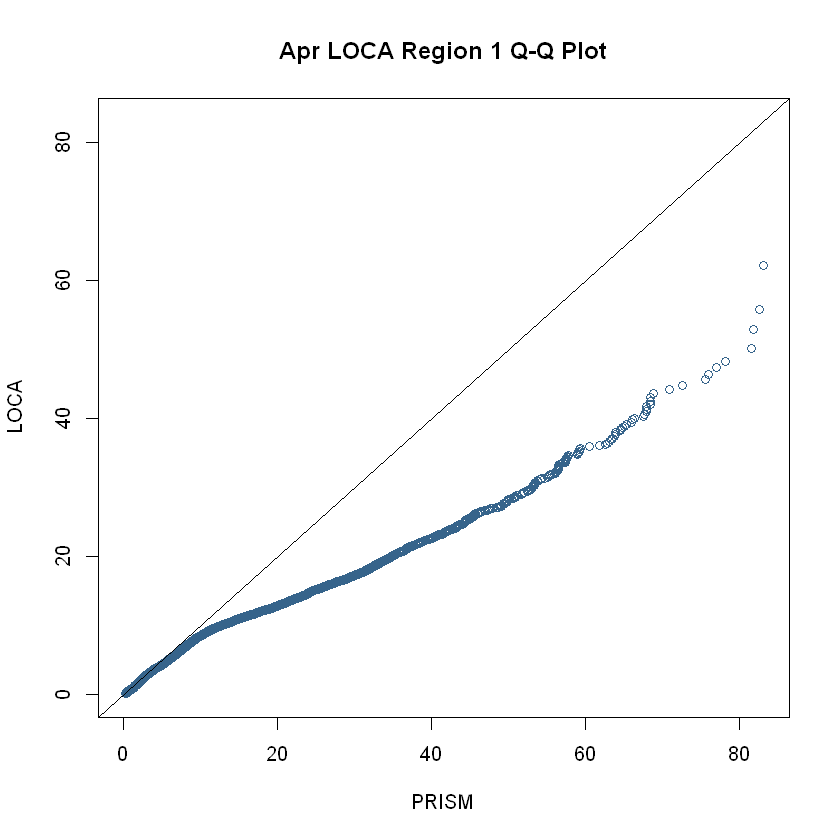

In [25]:
wApr1Max <- max( max( dfPRApr1$Precip_mm ), max( dfLOApr1$Precip_mm ) )
qqplot( dfPRApr1$Precip_mm, dfLOApr1$Precip_mm, col="steelblue4", xlab="PRISM",
        ylab="LOCA", main="Apr LOCA Region 1 Q-Q Plot",
        xlim=c(0,wApr1Max), ylim=c(0,wApr1Max) )
abline( 0, 1)

In [26]:
ksResLO2 <- ks.test( dfPRApr2$Precip_mm, dfLOApr2$Precip_mm )

In [27]:
AprLO2_KSStat <- ksResLO2$statistic
AprLO2_KSp <- ksResLO2$p.value
cat(" Apr LOCA Region 2 K-S stat: ", AprLO2_KSStat, "\n",
    "Apr LOCA Region 2 K-S p-value: ", AprLO2_KSp )

 Apr LOCA Region 2 K-S stat:  0.1043389 
 Apr LOCA Region 2 K-S p-value:  0

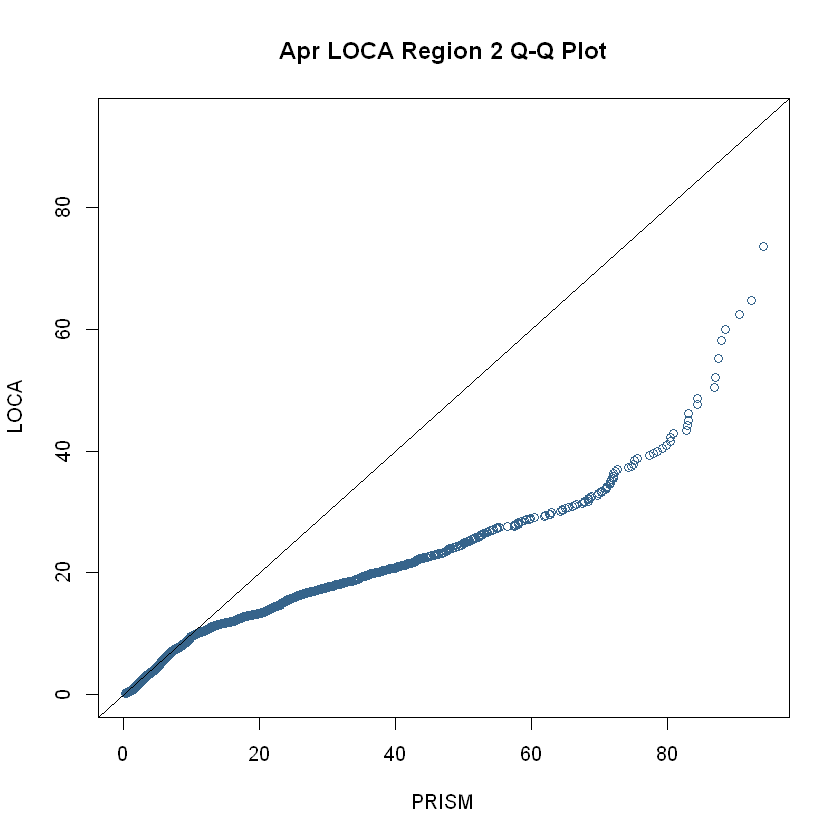

In [28]:
wApr2Max <- max( max( dfPRApr2$Precip_mm ), max( dfLOApr2$Precip_mm ) )
qqplot( dfPRApr2$Precip_mm, dfLOApr2$Precip_mm, col="steelblue4", xlab="PRISM",
        ylab="LOCA", main="Apr LOCA Region 2 Q-Q Plot",
        xlim=c(0,wApr2Max), ylim=c(0,wApr2Max) )
abline( 0, 1)

In [29]:
ksResLO3 <- ks.test( dfPRApr3$Precip_mm, dfLOApr3$Precip_mm )

In [30]:
AprLO3_KSStat <- ksResLO3$statistic
AprLO3_KSp <- ksResLO3$p.value
cat(" Apr LOCA Region 3 K-S stat: ", AprLO3_KSStat, "\n",
    "Apr LOCA Region 3 K-S p-value: ", AprLO3_KSp )

 Apr LOCA Region 3 K-S stat:  0.07424116 
 Apr LOCA Region 3 K-S p-value:  0

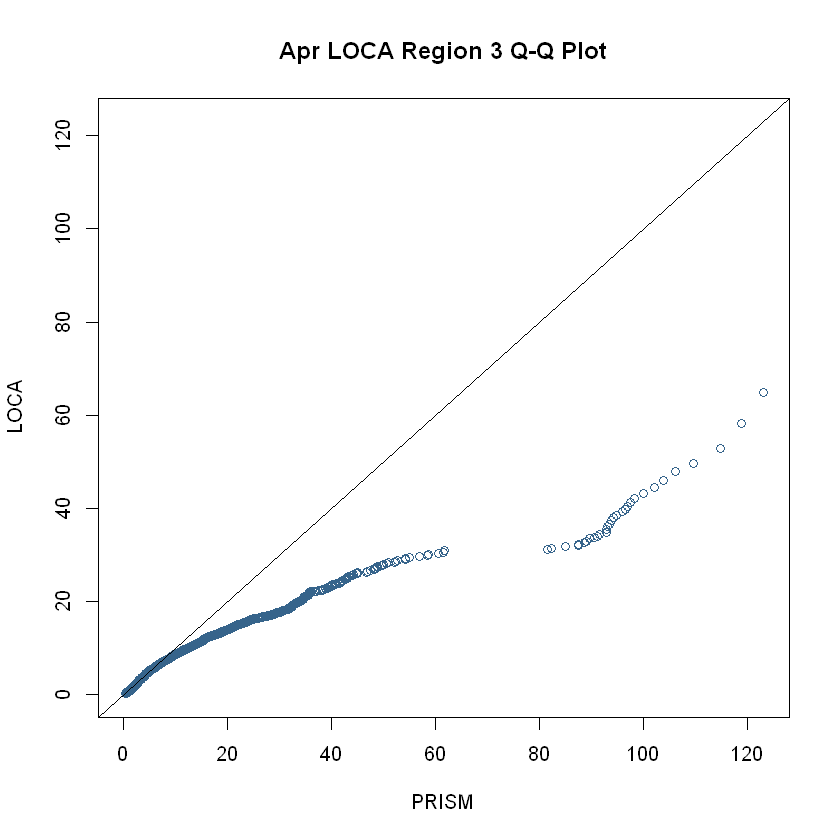

In [31]:
wApr3Max <- max( max( dfPRApr3$Precip_mm ), max( dfLOApr3$Precip_mm ) )
qqplot( dfPRApr3$Precip_mm, dfLOApr3$Precip_mm, col="steelblue4", xlab="PRISM",
        ylab="LOCA", main="Apr LOCA Region 3 Q-Q Plot",
        xlim=c(0,wApr3Max), ylim=c(0,wApr3Max) )
abline( 0, 1)

In [32]:
ksResLO4 <- ks.test( dfPRApr4$Precip_mm, dfLOApr4$Precip_mm )

In [33]:
AprLO4_KSStat <- ksResLO4$statistic
AprLO4_KSp <- ksResLO4$p.value
cat(" Apr LOCA Region 4 K-S stat: ", AprLO4_KSStat, "\n",
    "Apr LOCA Region 4 K-S p-value: ", AprLO4_KSp )

 Apr LOCA Region 4 K-S stat:  0.1142725 
 Apr LOCA Region 4 K-S p-value:  0

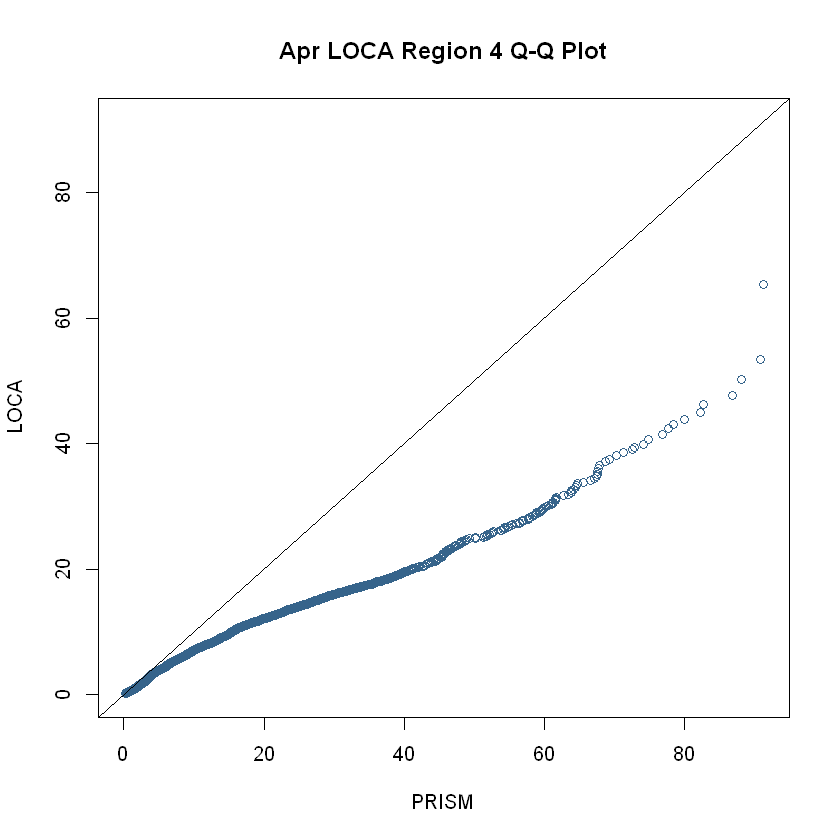

In [34]:
wApr4Max <- max( max( dfPRApr4$Precip_mm ), max( dfLOApr4$Precip_mm ) )
qqplot( dfPRApr4$Precip_mm, dfLOApr4$Precip_mm, col="steelblue4", xlab="PRISM",
        ylab="LOCA", main="Apr LOCA Region 4 Q-Q Plot",
        xlim=c(0,wApr4Max), ylim=c(0,wApr4Max) )
abline( 0, 1)

In [35]:
ksResBC1 <- ks.test( dfPRApr1$Precip_mm, dfBCApr1$Precip_mm )

In [36]:
AprBC1_KSStat <- ksResBC1$statistic
AprBC1_KSp <- ksResBC1$p.value
cat(" Apr BCCA Region 1 K-S stat: ", AprBC1_KSStat, "\n",
    "Apr BCCA Region 1 K-S p-value: ", AprBC1_KSp )

 Apr BCCA Region 1 K-S stat:  0.1623579 
 Apr BCCA Region 1 K-S p-value:  0

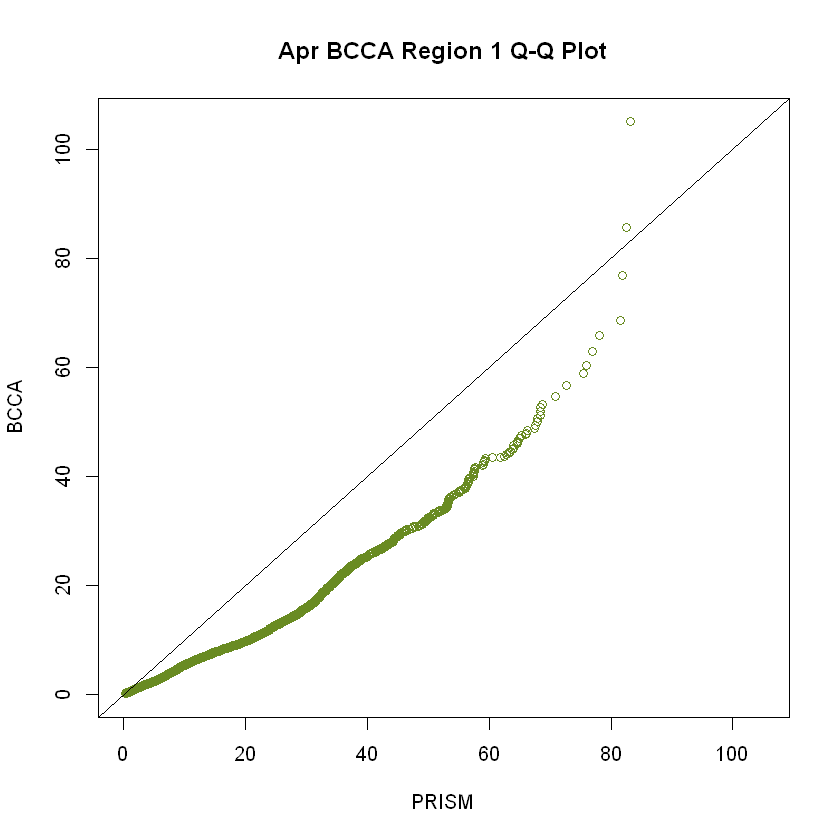

In [37]:
wApr1Max <- max( max( dfPRApr1$Precip_mm ), max( dfBCApr1$Precip_mm ) )
qqplot( dfPRApr1$Precip_mm, dfBCApr1$Precip_mm, col="olivedrab4", xlab="PRISM",
        ylab="BCCA", main="Apr BCCA Region 1 Q-Q Plot",
        xlim=c(0,wApr1Max), ylim=c(0,wApr1Max) )
abline( 0, 1)

In [38]:
ksResBC2 <- ks.test( dfPRApr2$Precip_mm, dfBCApr2$Precip_mm )

In [39]:
AprBC2_KSStat <- ksResBC2$statistic
AprBC2_KSp <- ksResBC2$p.value
cat(" Apr BCCA Region 2 K-S stat: ", AprBC2_KSStat, "\n",
    "Apr BCCA Region 2 K-S p-value: ", AprBC2_KSp )

 Apr BCCA Region 2 K-S stat:  0.233729 
 Apr BCCA Region 2 K-S p-value:  0

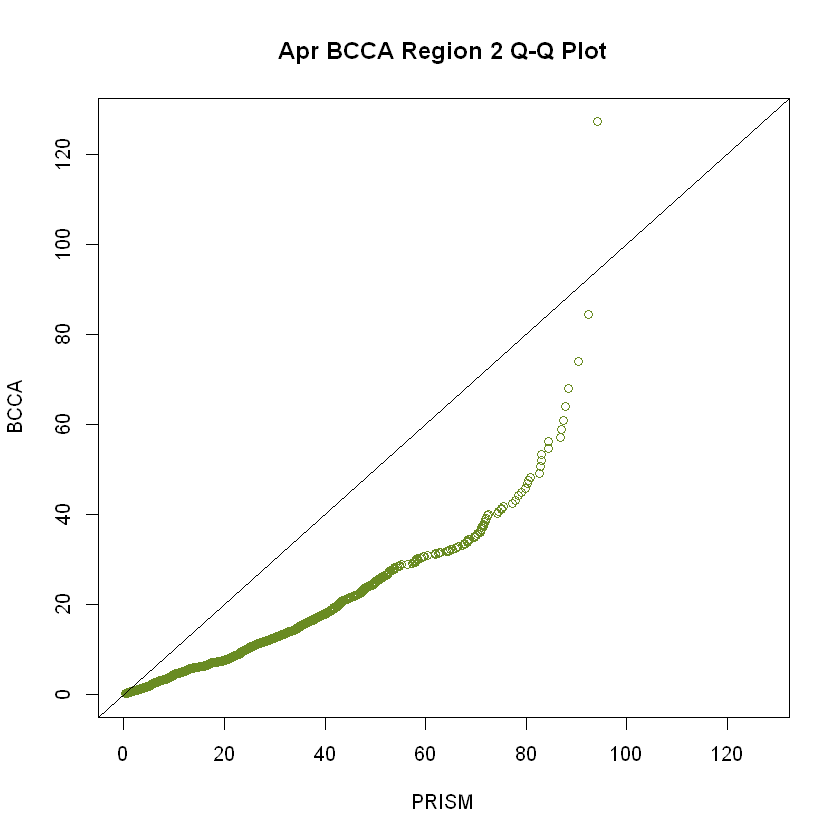

In [40]:
wApr2Max <- max( max( dfPRApr2$Precip_mm ), max( dfBCApr2$Precip_mm ) )
qqplot( dfPRApr2$Precip_mm, dfBCApr2$Precip_mm, col="olivedrab4", xlab="PRISM",
        ylab="BCCA", main="Apr BCCA Region 2 Q-Q Plot",
        xlim=c(0,wApr2Max), ylim=c(0,wApr2Max) )
abline( 0, 1)

In [41]:
ksResBC3 <- ks.test( dfPRApr3$Precip_mm, dfBCApr3$Precip_mm )

In [42]:
AprBC3_KSStat <- ksResBC3$statistic
AprBC3_KSp <- ksResBC3$p.value
cat(" Apr BCCA Region 3 K-S stat: ", AprBC3_KSStat, "\n",
    "Apr BCCA Region 3 K-S p-value: ", AprBC3_KSp )

 Apr BCCA Region 3 K-S stat:  0.1681375 
 Apr BCCA Region 3 K-S p-value:  0

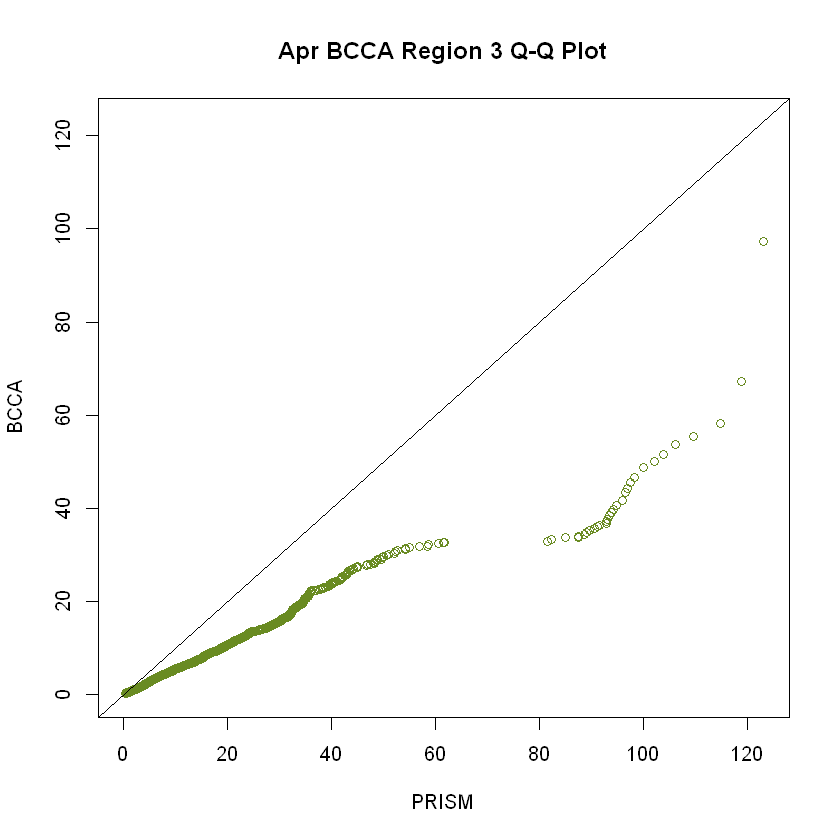

In [43]:
wApr3Max <- max( max( dfPRApr3$Precip_mm ), max( dfBCApr3$Precip_mm ) )
qqplot( dfPRApr3$Precip_mm, dfBCApr3$Precip_mm, col="olivedrab4", xlab="PRISM",
        ylab="BCCA", main="Apr BCCA Region 3 Q-Q Plot",
        xlim=c(0,wApr3Max), ylim=c(0,wApr3Max) )
abline( 0, 1)

In [44]:
ksResBC4 <- ks.test( dfPRApr4$Precip_mm, dfBCApr4$Precip_mm )

In [45]:
AprBC4_KSStat <- ksResBC4$statistic
AprBC4_KSp <- ksResBC4$p.value
cat(" Apr BCCA Region 4 K-S stat: ", AprBC4_KSStat, "\n",
    "Apr BCCA Region 4 K-S p-value: ", AprBC4_KSp )

 Apr BCCA Region 4 K-S stat:  0.2091412 
 Apr BCCA Region 4 K-S p-value:  0

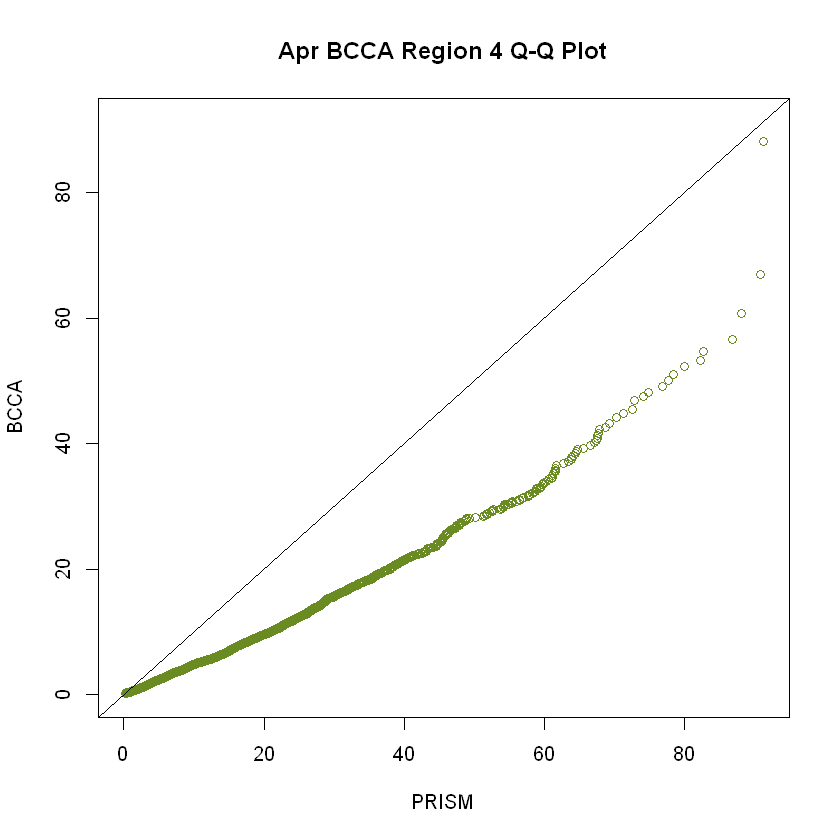

In [46]:
wApr4Max <- max( max( dfPRApr4$Precip_mm ), max( dfBCApr4$Precip_mm ) )
qqplot( dfPRApr4$Precip_mm, dfBCApr4$Precip_mm, col="olivedrab4", xlab="PRISM",
        ylab="BCCA", main="Apr BCCA Region 4 Q-Q Plot",
        xlim=c(0,wApr4Max), ylim=c(0,wApr4Max) )
abline( 0, 1)

## Output Stats and Distribution Fits to Spreadsheet

In [47]:
setwd("//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/R/Working/CMIP5_1981_PDepth")

In [48]:
outputDF_xlsx <- createWorkbook()

In [49]:
AprLO_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Apr_LOCA")
AprBC_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Apr_BCCA")

In [50]:
addDataFrame( x=MonLODistDF, sheet=AprLO_xlsx )
addDataFrame( x=MonBCDistDF, sheet=AprBC_xlsx )

In [51]:
saveWorkbook( outputDF_xlsx, file="CMIP5_2010_AprDistFits.xlsx" )

In [52]:
options(warn = oldw)